# Init

In [1]:
%matplotlib inline

import csv
import itertools
import math
import matplotlib
import time
import logging
import sys
import os
import random
import warnings

import gensim

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn import random_projection
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags
from scipy.io import loadmat, savemat
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MultiLabelBinarizer

In [2]:
from sklearn import preprocessing

In [3]:
from scoring import scoring
from fastrp_exp import *

In [4]:
# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from jupyter_client import find_connection_file

In [7]:
find_connection_file()

'/run/user/2002/jupyter/kernel-cd9d0d40-6687-4975-b87c-7be83cb79b87.json'

In [8]:
matplotlib.style.use('ggplot')
sns.set(color_codes=True)

# Load Data

## Flickr

In [9]:
flickr = loadmat('example_graphs/flickr.mat')
A = flickr['network']
N = A.shape[0]

In [10]:
flickr['group']

<80513x195 sparse matrix of type '<class 'numpy.float64'>'
	with 107741 stored elements in Compressed Sparse Column format>

In [11]:
A

<80513x80513 sparse matrix of type '<class 'numpy.float64'>'
	with 11799764 stored elements in Compressed Sparse Column format>

In [13]:
d = [l[0] for l in A.sum(axis=1).tolist()]

In [15]:
import powerlaw

alpha=  1.2195772593015188   sigma=  0.0007738456674406795


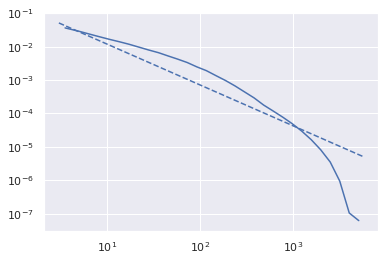

In [16]:
fit = powerlaw.Fit(np.array(d)+1,xmin=1,discrete=True)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

# Measure Runtime

In [36]:
%%time
prefix = 'result/flickr'
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, 7.81, 45.28],
        'normalization': False,
        'dim': 512,
        'alpha': -0.628,
        'C': 1.0
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# savemat(emb_filename, {'emb': U})

result/flickr-dim=512,projection_method=sparse,input_matrix=trans,normalization=False,weights=1.0,1.0,7.81,45.28,alpha=-0.628,C=1.0.mat
CPU times: user 151 µs, sys: 2 µs, total: 153 µs
Wall time: 142 µs


In [39]:
%time U = fastrp_wrapper(A, conf)

CPU times: user 29.6 s, sys: 3.56 s, total: 33.1 s
Wall time: 19.9 s


In [19]:
N

80513

# Intelligent Hyperparameter Search

In [19]:
import optuna

In [20]:
prefix = 'result/flickr'

In [21]:
%%time
order_range = 1
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    weights = [trial.suggest_loguniform('weight' + str(order), 1.0, 64.0) for order in range(order_range)]
    alpha = trial.suggest_uniform('alpha', -1.0, 0.0)
    conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [0, 0, 1] + weights,
        'normalization': True,
        'dim': 64,
        'alpha': alpha,
        'C': 0.1
    }
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = fastrp_wrapper(A, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = scoring(
        [
            "--emb", emb_filename,
            "--network","example_graphs/flickr.mat",
            "--num-shuffles", "3",
            "--debug",
            "--C", str(conf['C']),
            "--training-percents", "1",
        ]
    )
    # there should only be one entry here
    return -f1_scores[0]['micro'] - f1_scores[0]['macro']

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=20)  # Invoke optimization of the objective function.

result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,24.346785642695952,alpha=-0.44546674307102396,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.29370639877185134, 'macro': 0.10180336163366153}
-------------------


[I 2019-05-20 14:42:43,096] Finished trial#0 resulted in value: -0.3955097604055129. Current best value is -0.3955097604055129 with parameters: {'weight0': 24.346785642695952, 'alpha': -0.44546674307102396}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,18.917256446688224,alpha=-0.3253660844827566,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.29389711249563955, 'macro': 0.09554633411914322}
-------------------


[I 2019-05-20 14:43:06,224] Finished trial#1 resulted in value: -0.38944344661478275. Current best value is -0.3955097604055129 with parameters: {'weight0': 24.346785642695952, 'alpha': -0.44546674307102396}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,2.4528504142134215,alpha=-0.44276296533786286,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.29794169725193936, 'macro': 0.1031840338348304}
-------------------


[I 2019-05-20 14:43:29,024] Finished trial#2 resulted in value: -0.40112573108676974. Current best value is -0.40112573108676974 with parameters: {'weight0': 2.4528504142134215, 'alpha': -0.44276296533786286}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,2.048878253239231,alpha=-0.5735238556253189,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.2944378645437638, 'macro': 0.10266629607993723}
-------------------


[I 2019-05-20 14:43:51,844] Finished trial#3 resulted in value: -0.397104160623701. Current best value is -0.40112573108676974 with parameters: {'weight0': 2.4528504142134215, 'alpha': -0.44276296533786286}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,2.9074492611008225,alpha=-0.058428075728750195,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.3050953810891351, 'macro': 0.10177144998031291}
-------------------


[I 2019-05-20 14:44:14,404] Finished trial#4 resulted in value: -0.406866831069448. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,25.308959899525625,alpha=-0.40883686289709176,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.29558377549473697, 'macro': 0.09637151513719526}
-------------------


[I 2019-05-20 14:44:36,577] Finished trial#5 resulted in value: -0.39195529063193224. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,14.682545298182538,alpha=-0.37234210366377474,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.29689499390226654, 'macro': 0.09936734502629509}
-------------------


[I 2019-05-20 14:44:58,910] Finished trial#6 resulted in value: -0.3962623389285616. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,29.534426239414163,alpha=-0.9702080169474067,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.27828047547437346, 'macro': 0.09419891150633658}
-------------------


[I 2019-05-20 14:45:21,480] Finished trial#7 resulted in value: -0.37247938698071004. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,19.063434876197984,alpha=-0.19450665778478005,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.3025989739157862, 'macro': 0.10309638046094143}
-------------------


[I 2019-05-20 14:45:44,614] Finished trial#8 resulted in value: -0.40569535437672766. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,46.90737987756933,alpha=-0.5072914506905198,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.29337259426483525, 'macro': 0.09738166997071789}
-------------------


[I 2019-05-20 14:46:07,182] Finished trial#9 resulted in value: -0.39075426423555315. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,6.034564944579056,alpha=-0.012563486101810982,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.3026133263541794, 'macro': 0.09609236509617125}
-------------------


[I 2019-05-20 14:46:30,422] Finished trial#10 resulted in value: -0.3987056914503507. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,4.6810701996590955,alpha=-0.743428499134677,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.28420853530576234, 'macro': 0.09681433537717876}
-------------------


[I 2019-05-20 14:46:53,980] Finished trial#11 resulted in value: -0.3810228706829411. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,1.0638923193814427,alpha=-0.15426478248702424,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.3014921569684454, 'macro': 0.10146193528236387}
-------------------


[I 2019-05-20 14:47:17,498] Finished trial#12 resulted in value: -0.40295409225080925. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,2.608990000015626,alpha=-0.7683503551109695,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.2896550407266603, 'macro': 0.10303111070471295}
-------------------


[I 2019-05-20 14:47:40,142] Finished trial#13 resulted in value: -0.39268615143137325. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,9.27539308639621,alpha=-0.1441247820611382,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.3035645068229245, 'macro': 0.09928594057217649}
-------------------


[I 2019-05-20 14:48:03,089] Finished trial#14 resulted in value: -0.402850447395101. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,3.6372663481073286,alpha=-0.003472823477070258,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.30522363109155015, 'macro': 0.09942898757138961}
-------------------


[I 2019-05-20 14:48:26,496] Finished trial#15 resulted in value: -0.4046526186629398. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,1.6059490481640746,alpha=-0.6819911498779107,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.28588755946760486, 'macro': 0.10184140073471783}
-------------------


[I 2019-05-20 14:48:49,105] Finished trial#16 resulted in value: -0.38772896020232267. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,8.827563325309582,alpha=-0.22007674571319946,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.3027587621579088, 'macro': 0.10164942533562708}
-------------------


[I 2019-05-20 14:49:11,527] Finished trial#17 resulted in value: -0.4044081874935359. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,11.765586310232159,alpha=-0.0751856768770322,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.298962982504428, 'macro': 0.09342008738436451}
-------------------


[I 2019-05-20 14:49:33,961] Finished trial#18 resulted in value: -0.3923830698887925. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


result/flickr-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,5.987595956082004,alpha=-0.23785716722031797,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.01
Average score: {'micro': 0.2974320819171797, 'macro': 0.09710930198508676}
-------------------


[I 2019-05-20 14:49:57,422] Finished trial#19 resulted in value: -0.39454138390226645. Current best value is -0.406866831069448 with parameters: {'weight0': 2.9074492611008225, 'alpha': -0.058428075728750195}.


CPU times: user 53min 32s, sys: 1min 36s, total: 55min 9s
Wall time: 7min 38s


In [23]:
%%time
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [0.0, 0.0, 1, 2.91],
        'normalization': True,
        'dim': 512,
        'alpha': -0.058,
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = fastrp_wrapper(A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/flickr.mat",
        "--num-shuffles", "5",
        # "--all",
        "--debug",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(1, 10)]
)
f1_scores

result/flickr-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=0.0,0.0,1,2.91,alpha=-0.058,C=0.1.mat
Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.31831960403324394, 'macro': 0.14338058352024635}
-------------------
Train percent: 0.02
Average score: {'micro': 0.33897452842378745, 'macro': 0.17943038134936323}
-------------------
Train percent: 0.03
Average score: {'micro': 0.3482875795654713, 'macro': 0.19452597037600103}
-------------------
Train percent: 0.04
Average score: {'micro': 0.35550481783835863, 'macro': 0.2097328167928501}
-------------------
Train percent: 0.05
Average score: {'micro': 0.36058110013805994, 'macro': 0.22136593647686706}
-------------------
Train percent: 0.06
Average score: {'micro'

In [50]:
study.best_value

-0.46019485661993353

In [54]:
for trail in study.trials:
    if trail.value < -0.45:
        print (trail)

FrozenTrial(number=16, state=<TrialState.COMPLETE: 1>, value=-0.4563146009073586, datetime_start=datetime.datetime(2019, 5, 17, 4, 17, 19, 543801), datetime_complete=datetime.datetime(2019, 5, 17, 4, 19, 53, 37107), params={'weight0': 4.865656300040944, 'weight1': 36.027259223674406, 'alpha': -0.017345318735447146}, user_attrs={}, system_attrs={'_number': 16}, intermediate_values={}, params_in_internal_repr={'weight0': 4.865656300040944, 'weight1': 36.027259223674406, 'alpha': -0.017345318735447146}, trial_id=16)
FrozenTrial(number=17, state=<TrialState.COMPLETE: 1>, value=-0.4520473285917916, datetime_start=datetime.datetime(2019, 5, 17, 4, 19, 53, 40982), datetime_complete=datetime.datetime(2019, 5, 17, 4, 22, 26, 686139), params={'weight0': 4.79789066153359, 'weight1': 36.79554236833669, 'alpha': -0.005511464483578865}, user_attrs={}, system_attrs={'_number': 17}, intermediate_values={}, params_in_internal_repr={'weight0': 4.79789066153359, 'weight1': 36.79554236833669, 'alpha': -0.

In [87]:
study.best_params

{'weight0': 13.964714097160938,
 'weight1': 34.09283123647822,
 'alpha': -0.015958081665357893}

In [46]:
study.best_params

{'weight0': 1.5862487812039132,
 'weight1': 3.4145137895287307,
 'alpha': -0.6081526161207382}

In [ ]:
%%time
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [0.0, 0.0, 1.5862487812039132, 3.4145137895287307],
        'normalization': True,
        'dim': 512,
        'alpha': -0.6081526161207382,
        'C': 1.0
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = randne_wrapper(flickr_A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/flickr.mat",
        "--num-shuffles", "5",
        # "--all",
        "--debug",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(1, 10)]
)
f1_scores

In [88]:
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, 13.96, 34.09],
        'normalization': True,
        'dim': 512,
        'alpha': -0.015958081665357893,
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = randne_wrapper(flickr_A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/flickr.mat",
        "--num-shuffles", "5",
        # "--all",
        "--debug",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(1, 10)]
)
f1_scores

result/flickr-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,13.96,34.09,alpha=-0.015958081665357893,C=0.1.mat
Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.3151097617762727, 'macro': 0.15018592408378723}
-------------------
Train percent: 0.02
Average score: {'micro': 0.33667644039622835, 'macro': 0.18484884454385186}
-------------------
Train percent: 0.03
Average score: {'micro': 0.3472779957986039, 'macro': 0.20065001904757648}
-------------------
Train percent: 0.04
Average score: {'micro': 0.3544728423957392, 'macro': 0.2143008812247599}
-------------------
Train percent: 0.05
Average score: {'micro': 0.360200789832703, 'macro': 0.2250956959296322}
-------------------
Train percent: 0.06
Average 

[defaultdict(float,
             {'micro': 0.3151097617762727,
              'macro': 0.15018592408378723,
              'training': 0.01}),
 defaultdict(float,
             {'micro': 0.33667644039622835,
              'macro': 0.18484884454385186,
              'training': 0.02}),
 defaultdict(float,
             {'micro': 0.3472779957986039,
              'macro': 0.20065001904757648,
              'training': 0.03}),
 defaultdict(float,
             {'micro': 0.3544728423957392,
              'macro': 0.2143008812247599,
              'training': 0.04}),
 defaultdict(float,
             {'micro': 0.360200789832703,
              'macro': 0.2250956959296322,
              'training': 0.05}),
 defaultdict(float,
             {'micro': 0.3644701870807795,
              'macro': 0.2321099030723331,
              'training': 0.06}),
 defaultdict(float,
             {'micro': 0.3676783864050029,
              'macro': 0.23744805560585264,
              'training': 0.07}),
 defaultdict(flo

In [ ]:
%%time
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 3.598, 24.90, 63.42],
        'normalization': True,
        'dim': 512,
        'alpha': 0.0,
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = randne_wrapper(flickr_A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/flickr.mat",
        "--num-shuffles", "5",
        "--all",
        "--debug",
        "--C", str(conf['C']),
    ],
)
f1_scores

For measuring runtime:

In [28]:
%%time
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 3.598, 24.90, 63.42],
        'normalization': True,
        'dim': 512,
        'alpha': 0.0,
        'C': 0.1
    }
U = randne_wrapper(flickr_A, conf)

CPU times: user 2min 25s, sys: 14 s, total: 2min 39s
Wall time: 2min 23s


# Run DeepWalk

Run the following command in shell:

In [ ]:
nohup time deepwalk --format mat --input example_graphs/flickr.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 28 --output example_graphs/flickr.emb &

In [10]:
%%time
dw_f1_scores = scoring(
    [
        "--emb", "/home/hcchen/deepwalk/example_graphs/flickr.emb",
        "--network","example_graphs/flickr.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)]
)
dw_f1_scores

Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.3196958784854066, 'macro': 0.13175708391819257}
-------------------
Train percent: 0.02
Average score: {'micro': 0.34375737623276503, 'macro': 0.1658567056382124}
-------------------
Train percent: 0.03
Average score: {'micro': 0.3574396515325928, 'macro': 0.19048875649457825}
-------------------
Train percent: 0.04
Average score: {'micro': 0.36672739201752097, 'macro': 0.20989459847832825}
-------------------
Train percent: 0.05
Average score: {'micro': 0.374106014943102, 'macro': 0.22290277119301435}
-------------------
Train percent: 0.06
Average score: {'micro': 0.37872647644481006, 'macro': 0.23154500124749805}
-------------------
Train percent: 0.07
Average score: {'micro': 0.38239910952208

# Run RandNE

In [ ]:
cd ~/RandNE-Python/ && 
time python3 src/randne.py --input /home/hcchen/fast-random-projection/example_graphs/flickr.mat \
--output /home/hcchen/fast-random-projection/result/flickr-randne-emb.mat \
--use-trans-matrix -q 3 -d 512 --weights 1 100 1000

In [29]:
%%time
randne_f1_scores = scoring(
    [
        "--emb", "result/flickr-randne-emb.mat",
        "--network","example_graphs/flickr.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
)
randne_f1_scores

Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.2925455127639275, 'macro': 0.13643325273038417}
-------------------
Train percent: 0.02
Average score: {'micro': 0.30953487868873153, 'macro': 0.16887877475205587}
-------------------
Train percent: 0.03
Average score: {'micro': 0.32188362118201114, 'macro': 0.191397722883543}
-------------------
Train percent: 0.04
Average score: {'micro': 0.3287802091350672, 'macro': 0.20637409274477422}
-------------------
Train percent: 0.05
Average score: {'micro': 0.3343719272901447, 'macro': 0.21588903480527946}
-------------------
Train percent: 0.06
Average score: {'micro': 0.3388651340080874, 'macro': 0.22316845902317933}
-------------------
Train percent: 0.07
Average score: {'micro': 0.3440269473642624, 'macro': 0.230997

# Run LINE

Save the graph as edgelist:

In [24]:
A

<80513x80513 sparse matrix of type '<class 'numpy.float64'>'
	with 11799764 stored elements in Compressed Sparse Column format>

In [25]:
G = nx.from_scipy_sparse_matrix(A)
G.number_of_nodes(), G.number_of_edges()

(80513, 5899882)

In [26]:
nx.write_edgelist(G.to_directed(), open('example_graphs/flickr.edgelist', 'wb'), data=['weight'])

Compile the code:

In [ ]:
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result line.cpp -o line -lgsl -lm -lgslcblas
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result reconstruct.cpp -o reconstruct
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result normalize.cpp -o normalize
g++ -I /home/hcchen/gsl/include -L /home/hcchen/gsl/lib -lm -pthread -Ofast -march=native -Wall -funroll-loops -ffast-math -Wno-unused-result concatenate.cpp -o concatenate

First add the GSL library to path in shell:

In [ ]:
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/hcchen/gsl/lib

Run LINE:

In [ ]:
cd ~/LINE/linux && nohup time ./line -train /home/hcchen/fast-random-projection/example_graphs/flickr.edgelist \
-output /home/hcchen/fast-random-projection/result/flickr.line.emb \
-binary 0 -size 200 -order 2 -negative 5 -samples 1000 -rho 0.025 -threads 40 &

In [27]:
%%time
line_f1_scores = scoring(
    [
        "--emb", "/home/hcchen/fast-random-projection/result/flickr.line.emb",
        "--network","example_graphs/flickr.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)]
)
line_f1_scores

Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 200
-------------------
Train percent: 0.01
Average score: {'micro': 0.2813013648817194, 'macro': 0.10691118031111965}
-------------------
Train percent: 0.02
Average score: {'micro': 0.2972879381625006, 'macro': 0.1300608316982415}
-------------------
Train percent: 0.03
Average score: {'micro': 0.3073894164182993, 'macro': 0.14634940855742729}
-------------------
Train percent: 0.04
Average score: {'micro': 0.3137905527433307, 'macro': 0.1575801113275311}
-------------------
Train percent: 0.05
Average score: {'micro': 0.3194337385977299, 'macro': 0.16524471652037645}
-------------------
Train percent: 0.06
Average score: {'micro': 0.3251038665413805, 'macro': 0.17345570261715232}
-------------------
Train percent: 0.07
Average score: {'micro': 0.32948150232647844

# Run node2vec

In [ ]:
cd /home/hcchen/deepwalk-sgns/deepwalk && nohup time python __main__.py --format mat \
--input /home/hcchen/deepwalk/example_graphs/flickr.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 40 --output /home/hcchen/deepwalk-sgns/example_graphs/flickr.node2vec.emb &

In [29]:
%%time
node2vec_f1_scores = scoring(
    [
        "--emb", "/home/hcchen/deepwalk-sgns/example_graphs/flickr.node2vec.emb",
        "--network","example_graphs/flickr.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
)
node2vec_f1_scores

Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.3106388832635548, 'macro': 0.11888892040293031}
-------------------
Train percent: 0.02
Average score: {'micro': 0.3373673515774205, 'macro': 0.16026257549678521}
-------------------
Train percent: 0.03
Average score: {'micro': 0.3519868588782164, 'macro': 0.18220861238273278}
-------------------
Train percent: 0.04
Average score: {'micro': 0.36091131201223464, 'macro': 0.19756936590012505}
-------------------
Train percent: 0.05
Average score: {'micro': 0.3674701181133152, 'macro': 0.20937977156288573}
-------------------
Train percent: 0.06
Average score: {'micro': 0.37441448211014683, 'macro': 0.2223428566886517}
-------------------
Train percent: 0.07
Average score: {'micro': 0.37860430849322